In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

CPU times: total: 5.67 s
Wall time: 26.8 s


# Getting The Data

In [2]:
def get_df_from_txtfile(path: str) -> pd.DataFrame:
    tweets = []
    labels = []
    
    with open(path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        tweet = line.split(";")[0]
        label = line.split(";")[1][:-1]

        tweets.append(tweet)
        labels.append(label)
        
    return pd.DataFrame( {"Tweet": tweets, "Emotion": labels} )

In [3]:
train_df = get_df_from_txtfile("data/train.txt")
val_df = get_df_from_txtfile("data/val.txt")
test_df = get_df_from_txtfile("data/test.txt")

In [4]:
print(train_df.shape)
train_df.head()

(16000, 2)


,Tweet,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
print(val_df.shape)
val_df.head()

(2000, 2)


,Tweet,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [6]:
print(test_df.shape)
test_df.head()

(2000, 2)


,Tweet,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


# Visualize Data

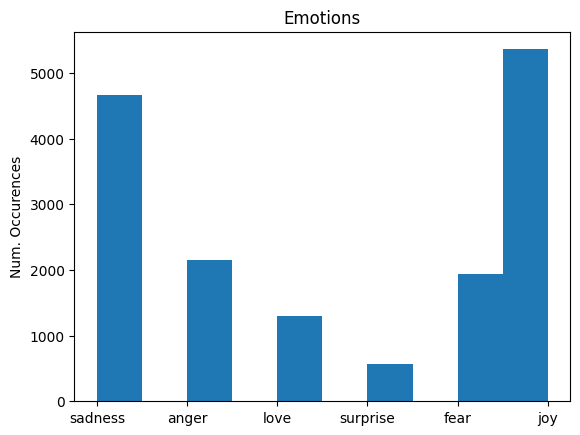

In [7]:
plt.hist(train_df["Emotion"])

plt.ylabel("Num. Occurences")
plt.title("Emotions")

plt.show()

# Tokenize Data

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10_000, oov_token="<UNK>")

tokenizer.fit_on_texts(train_df["Tweet"])

In [9]:
print(train_df["Tweet"][0])
tokenizer.texts_to_sequences([train_df["Tweet"][0]])

i didnt feel humiliated


[[2, 139, 3, 679]]

# Padding And Truncating

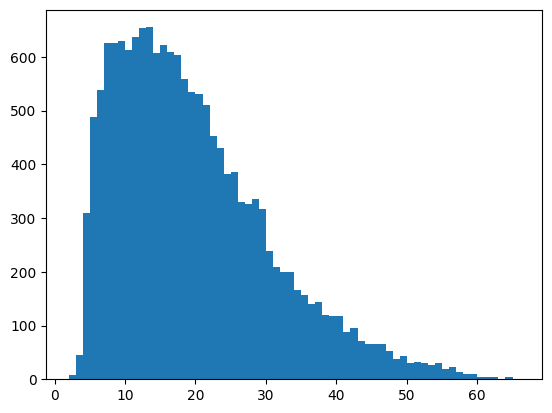

In [10]:
# Get lengths of tweets
lengths = [len(train_df["Tweet"][i].split(" ")) for i in range(len(train_df))]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

def get_sequence(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating="post", padding="post", maxlen=max_len)
    return padded

In [12]:
train_seq = get_sequence(tokenizer, train_df["Tweet"])
val_seq = get_sequence(tokenizer, val_df["Tweet"])
test_seq = get_sequence(tokenizer, test_df["Tweet"])

In [13]:
print(train_df["Tweet"][0])
train_seq[0]

i didnt feel humiliated


array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

# Make Words Into Numbers

In [14]:
emotion_to_num = {emotion: i for (i, emotion) in enumerate(set(train_df["Emotion"]))}
emotion_to_num

{'sadness': 0, 'love': 1, 'joy': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [48]:
num_to_emotion = {i: emotion for (emotion, i) in emotion_to_num.items()}
num_to_emotion

{0: 'sadness', 1: 'love', 2: 'joy', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [15]:
train_df["Label"] = list(map(lambda emotion: emotion_to_num[emotion], train_df["Emotion"]))
val_df["Label"] = list(map(lambda emotion: emotion_to_num[emotion], val_df["Emotion"]))
test_df["Label"] = list(map(lambda emotion: emotion_to_num[emotion], test_df["Emotion"]))

# Creating The Model

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10_000, 32, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(len(set(train_df["Emotion"])), activation="softmax")
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            320000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            8480      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 338486 (1.29 MB)
Trainable params: 338486 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Visualization Functions

In [18]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(true_labels, preds, classes):
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, preds, normalize="true")
    
    plt.figure(figsize=(8, 8))

    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)

    plt.xticks( range(0, 6), labels=classes )
    plt.yticks( range(0, 6), labels=classes )

    plt.colorbar(ctx)
    plt.show()


# Training The Model

In [20]:
history = model.fit(
    train_seq, train_df["Label"],
    validation_data=(val_seq, val_df["Label"]),
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
)

Epoch 1/20
500/500 [==============================] - 40s 54ms/step - loss: 1.3305 - accuracy: 0.4562 - val_loss: 0.7966 - val_accuracy: 0.7135
Epoch 2/20
500/500 [==============================] - 26s 52ms/step - loss: 0.5292 - accuracy: 0.8209 - val_loss: 0.5145 - val_accuracy: 0.8295
Epoch 3/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2975 - accuracy: 0.8996 - val_loss: 0.4084 - val_accuracy: 0.8580
Epoch 4/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2008 - accuracy: 0.9318 - val_loss: 0.3574 - val_accuracy: 0.8855
Epoch 5/20
500/500 [==============================] - 24s 47ms/step - loss: 0.1555 - accuracy: 0.9488 - val_loss: 0.3632 - val_accuracy: 0.8900
Epoch 6/20
500/500 [==============================] - 24s 48ms/step - loss: 0.1088 - accuracy: 0.9639 - val_loss: 0.3614 - val_accuracy: 0.8960
Epoch 7/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0798 - accuracy: 0.9746 - val_loss: 0.3783 - val_accuracy:

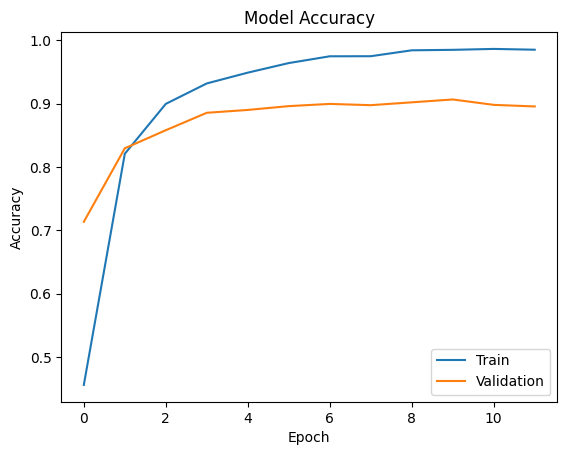

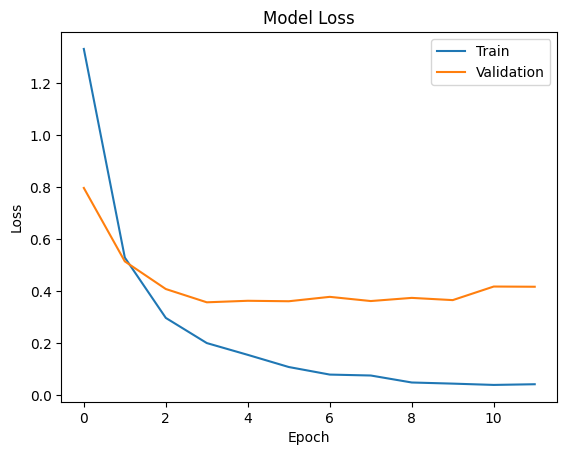

In [21]:
plot_training_history(history)

# Saving The Model

In [22]:
# Save the weights
model.save_weights('./model/model')

# Evaluating The Model On Test Data

In [23]:
loss, accuracy = model.evaluate(test_seq, test_df["Label"])

print(f"Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

63/63 [==============================] - 1s 20ms/step - loss: 0.4399 - accuracy: 0.8860
Accuracy: 0.89, Loss: 0.44


63/63 [==============================] - 5s 20ms/step


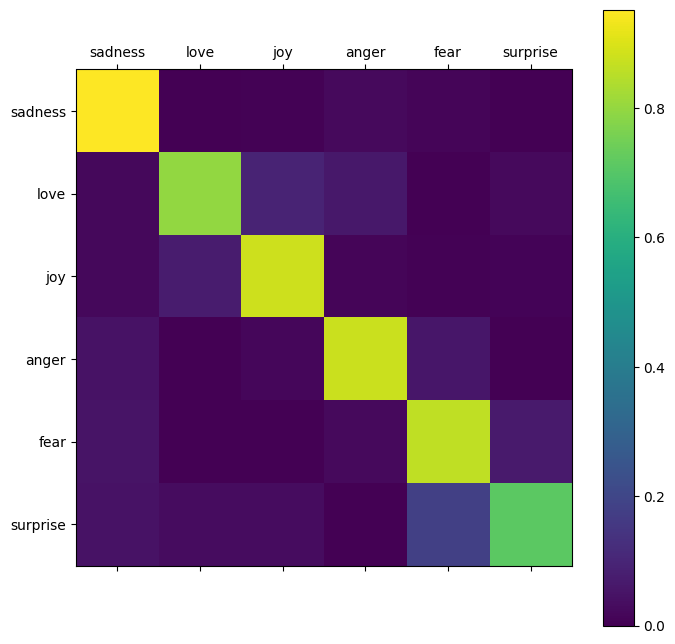

In [24]:
preds = np.array( model.predict(test_seq) ).argmax(axis=-1)

show_confusion_matrix(np.array(test_df["Label"]), preds, list(set(train_df["Emotion"])))

# Evaluating The Model On Custom Data

In [148]:
text = "i am the happiest man alive"

preds = model.predict( get_sequence(tokenizer, [text]) ).reshape(-1,)

emotion_prob = list(zip(emotion_to_num.keys(), preds.tolist()))
sorted_preds = sorted( preds.tolist(), reverse=True )

for pred in sorted_preds:
    for emotion, prob in emotion_prob:
        if prob == pred:
            spaces = "".join([" " for i in range(10 - len(emotion))])
            print(emotion.capitalize(), spaces, ":", str(round(prob*100, 2))+"%")

1/1 [==============================] - 0s 47ms/step
Joy         : 40.43%
Surprise    : 21.33%
Love        : 18.25%
Sadness     : 7.51%
Fear        : 6.27%
Anger       : 6.21%
